In [1]:
import numpy as np
import matplotlib.pyplot as plt

import jax as jx
import jax.numpy as jnp
from jax.example_libraries import optimizers
from functools import partial

from tqdm import tqdm

key = jx.random.PRNGKey(0)

In [2]:
def init_params(layers, key):
  # Glorot initialization
  Ws = []
  bs = []
  for i in range(len(layers) - 1):
    std_glorot = jnp.sqrt(2/(layers[i] + layers[i + 1]))
    key, subkey = jx.random.split(key)
    Ws.append(jx.random.normal(subkey, (layers[i], layers[i + 1]))*std_glorot)
    bs.append(jnp.zeros(layers[i + 1]))    
    # key, subkey = jx.random.split(key)
    # bs.append(jx.random.normal(subkey, (layers[i + 1],))*std_glorot)
  return [Ws, bs]

@jx.jit
def forward_pass(H, params):
  # Forward pass with tanh
  Ws = params[0]
  bs = params[1]
  N_layers = len(Ws)
  for i in range(N_layers - 1):
    H = jnp.matmul(H, Ws[i]) + bs[i]
    H = jx.nn.relu(H)
    # H = jnp.tanh(H)
  Y = jnp.matmul(H, Ws[-1]) + bs[-1]
  return Y

def create_grads():
  fp_wrapper = lambda x, params: forward_pass(x, params)[0]
  du_dx = jx.grad(fp_wrapper)
  du_dx_wrapper = lambda x, params: du_dx(x, params)[0]
  dU_dx = jx.vmap(du_dx,in_axes=(0,None), out_axes=0)
  dU_dxx = jx.vmap(jx.grad(du_dx_wrapper),in_axes=(0,None), out_axes=0)
  return dU_dx, dU_dxx

grad_X, grad_XX = create_grads()

@partial(jx.jit, static_argnums=(0,))
def step(loss, i, opt_state, X_batch, Y_batch):
    # Optimizer step
    params = get_params(opt_state)
    g = jx.grad(loss)(params, X_batch, Y_batch)
    return opt_update(i, g, opt_state)

def train(loss, X, Y, X_c, opt_state, X_bd = None, X_bn = None, nIter = 10000, stop=1e-5):
    train_loss = []
    val_loss = []
    key = jx.random.PRNGKey(0)
    for it in (pbar := tqdm(range(nIter))):
        opt_state = step(loss, it, opt_state, X, Y)
        if it % 50 == 0:
            params = get_params(opt_state)
            train_loss_value = loss(params, X, Y)
            train_loss.append(train_loss_value)
            to_print = "it %i, train loss = %e" % (it, train_loss_value)
            pbar.set_description(f"{to_print}")
            if train_loss_value<stop:break
    return get_params(opt_state), train_loss, val_loss

@jx.jit
def one_pass(H, params):
  # Forward pass with tanh
  Ws = params[0]
  bs = params[1]
  N_layers = len(Ws)
  for i in range(N_layers - 1):
    H = jnp.matmul(H, Ws[i]) + bs[i]
    H = jx.nn.relu(H)
  return H

def train_ls(loss, X, Y, X_c, opt_state, X_bd = None, X_bn = None, nIter = 10000, stop=1e-5):
    train_loss = []
    val_loss = []
    key = jx.random.PRNGKey(0)
    for it in (pbar := tqdm(range(nIter))):
        opt_state = step(loss, it, opt_state, X, Y)
        params = get_params(opt_state)

        res_last = one_pass(X, params)
        vec_ext = jnp.c_[res_last, 1+0*res_last[:,0]]
        ls = (jnp.linalg.pinv(vec_ext)@Y)

        params[0][-1] = ls[:-1]
        params[1][-1] = ls[-1:]
        opt_state = opt_init(params)

        if it % 50 == 0:
            params = get_params(opt_state)
            train_loss_value = loss(params, X, Y)
            train_loss.append(train_loss_value)
            to_print = "it %i, train loss = %e" % (it, train_loss_value)
            pbar.set_description(f"{to_print}")
            if train_loss_value<stop:break
    return get_params(opt_state), train_loss, val_loss


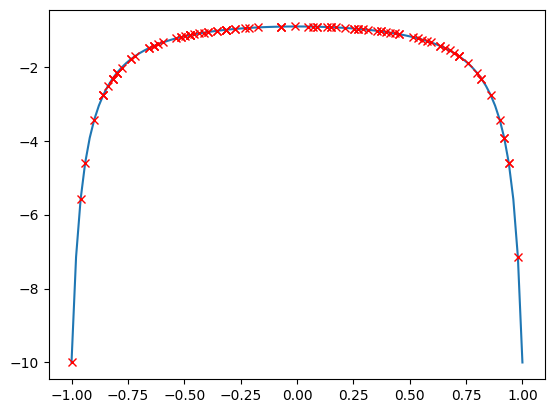

In [3]:
X = np.linspace(-1, 1, 100)[:, None]
Y = 1/(X**2-1.1)#np.cos(8.*X*np.pi)*np.exp(-8*X)
# Y /= Y.max()

rng_agent = np.random.default_rng(6516)
train_samples = rng_agent.choice(X.shape[0], 100)
X_train = X[train_samples]
Y_train = Y[train_samples]

plt.plot(X, Y)
plt.plot(X_train, Y_train, "rx")
plt.show()

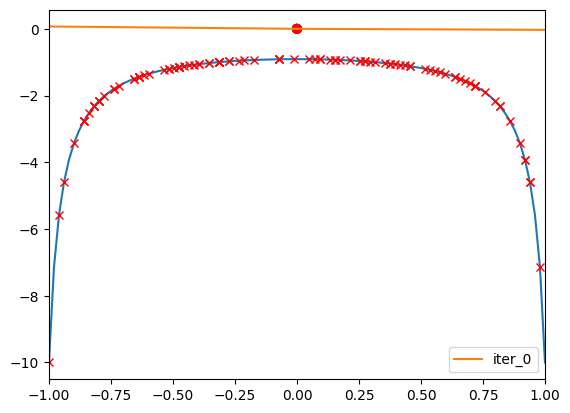

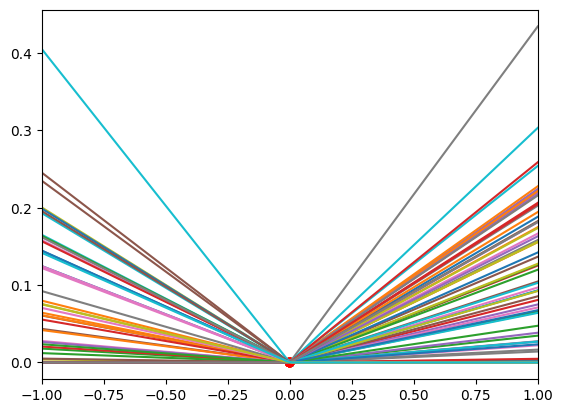

it 950, train loss = 9.299445e-01: 100%|████████████████████████████████████████████| 1000/1000 [00:15<00:00, 65.11it/s]


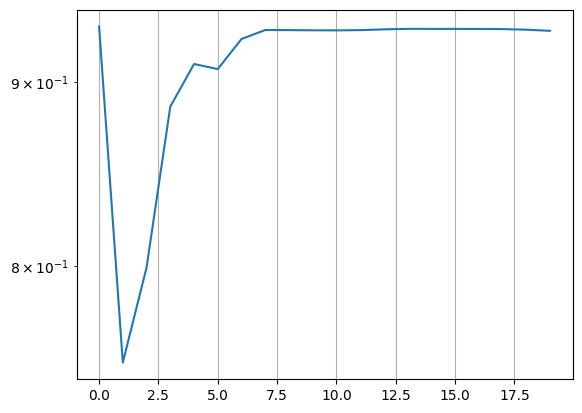

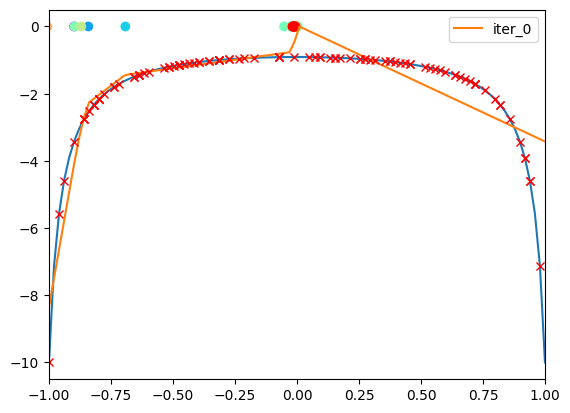

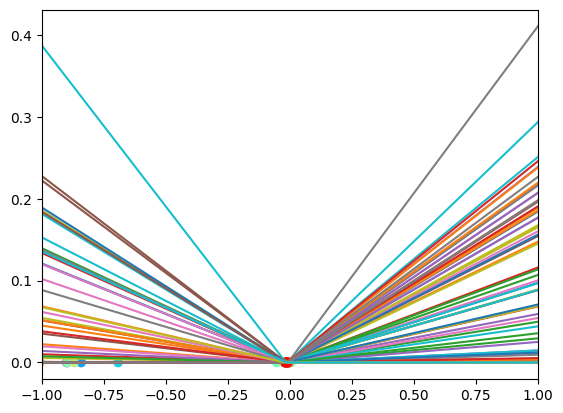

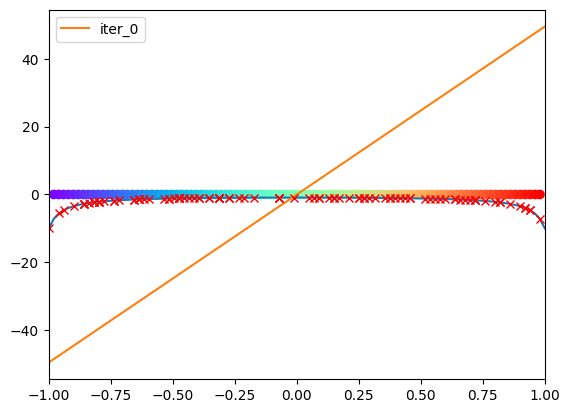

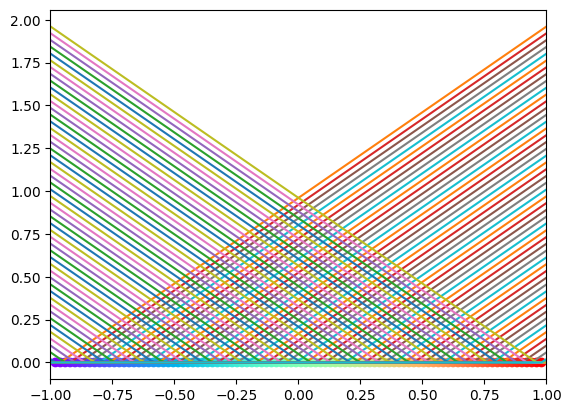

it 950, train loss = 7.791191e-07: 100%|████████████████████████████████████████████| 1000/1000 [00:17<00:00, 58.58it/s]


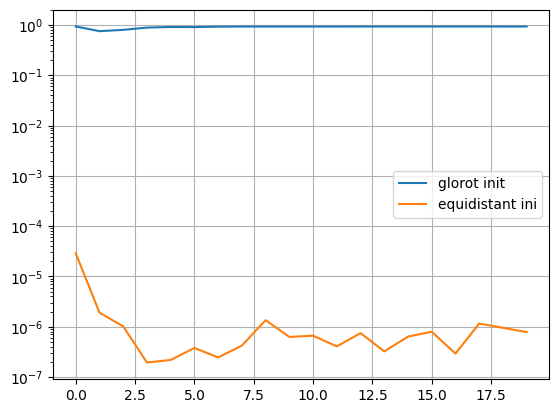

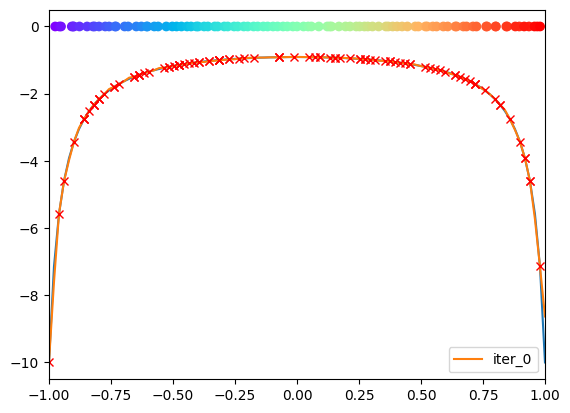

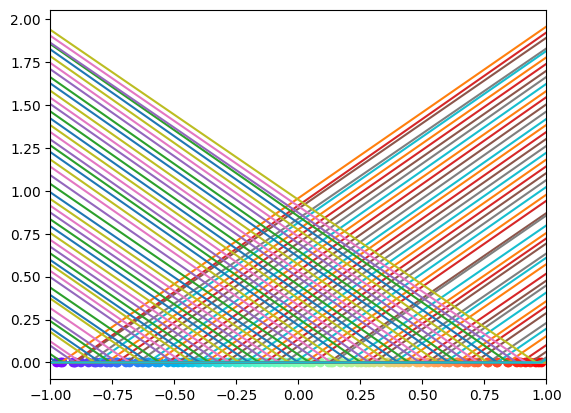

In [4]:
layers = [1] + [100]*1 + [1]
nIter = 1000
lr = 1e-4

key = jx.random.PRNGKey(0)
def init_params_modi(layers, key):
  # Glorot initialization
  Ws = []
  bs = []
  for i in range(len(layers) - 1):
    std_glorot = jnp.sqrt(2/(layers[i] + layers[i + 1]))
    key, subkey = jx.random.split(key)
    c = jnp.linspace(-1, 1, layers[i + 1]+2)[1:-1]
    # Ws.append(jx.random.normal(subkey, (layers[i], layers[i + 1]))*std_glorot)
    # Ws.append(jnp.sign(jx.random.normal(subkey, (layers[i], layers[i + 1]))))
    # W = jx.random.normal(subkey, (layers[i], layers[i + 1]))+1
    W = np.ones((layers[i], layers[i + 1]))
    # W = np.array(W)
    W[::2,::2]*=-1

    Ws.append(W)
    # Ws.append(jnp.ones((layers[i], layers[i + 1])))
    # bs.append(jnp.zeros(layers[i + 1]))    
    bs.append(-W[0]*c)
  return [Ws, bs]

params_glorot = init_params(layers, key)

opt_init, opt_update, get_params = optimizers.adam(lr)
opt_state = opt_init(params_glorot)
def plt_state(params):
  W0, b0 = params
  W0 = W0[0]
  b0 = b0[0]
  plt.plot(X, Y)
  plt.plot(X, forward_pass(X, params), label="iter_0")
  plt.plot(X_train, Y_train, "rx")
  plt.scatter(-b0/W0[0], [0]*b0.shape[0], c=np.linspace(0, 1, b0.shape[0]), cmap="rainbow")
  plt.xlim(-1, 1)
  plt.legend()
  plt.show()

  plt.plot(X, jx.nn.relu(X@W0+b0))
  plt.scatter(-b0/W0[0], [0]*b0.shape[0], c=np.linspace(0, 1, b0.shape[0]), cmap="rainbow")
  plt.xlim(-1, 1)
  plt.show()

plt_state(params_glorot)

@jx.jit
def loss(params, X, Y):
    Y_pred = forward_pass(X, params)
    MSE = jnp.mean((Y_pred-Y)**2)
    return  MSE

# params, train_loss, val_loss = train(loss, X_train, Y_train, None, opt_state, nIter = nIter)
params_glorot, train_loss, val_loss = train_ls(loss, X_train, Y_train, None, opt_state, nIter = nIter, stop=1e-8)
opt_state = opt_init(params_glorot)

plt.semilogy()
plt.plot(train_loss)
plt.grid()
plt.show()

plt_state(params_glorot)

#modified init

params = init_params_modi(layers, key)

opt_init, opt_update, get_params = optimizers.adam(lr)
opt_state = opt_init(params)

plt_state(params)

# params, train_loss, val_loss = train(loss, X_train, Y_train, None, opt_state, nIter = nIter)
params, train_loss2, val_loss2 = train_ls(loss, X_train, Y_train, None, opt_state, nIter = nIter, stop=1e-8)
opt_state = opt_init(params)

plt.semilogy()
plt.plot(train_loss, label="glorot init")
plt.plot(train_loss2, label="equidistant ini")
plt.legend()
plt.grid()
plt.show()

plt_state(params)

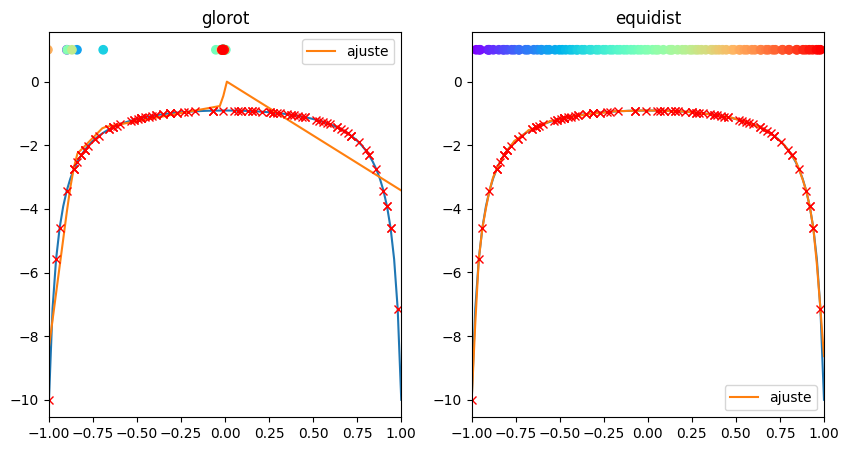

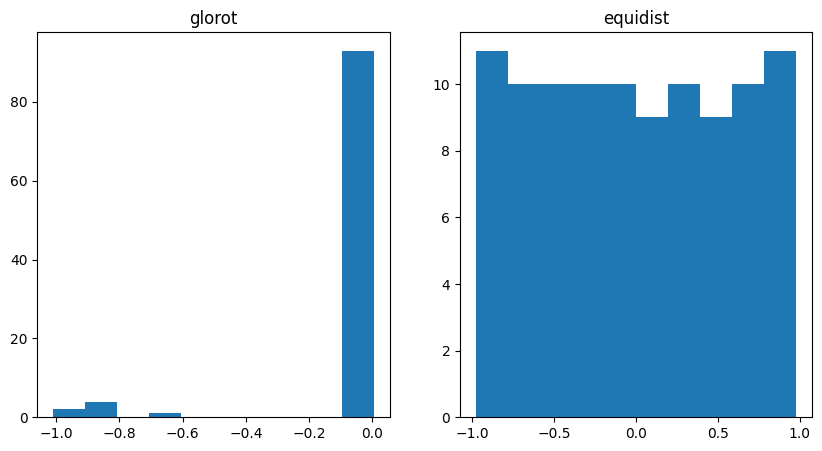

In [12]:
fig = plt.figure(figsize=(10, 5))
ax = fig.subplots(1,2)
W0, b0 = params_glorot
W0 = W0[0]
b0 = b0[0]
ax[0].plot(X, Y)
ax[0].plot(X, forward_pass(X, params_glorot), label="ajuste")
ax[0].plot(X_train, Y_train, "rx")
ax[0].scatter(-b0/W0[0], [1]*b0.shape[0], c=np.linspace(0, 1, b0.shape[0]), cmap="rainbow")
ax[0].set_xlim(-1, 1)
ax[0].legend()
W0, b0 = params
W0 = W0[0]
b0 = b0[0]
ax[1].plot(X, Y)
ax[1].plot(X, forward_pass(X, params), label="ajuste")
ax[1].plot(X_train, Y_train, "rx")
ax[1].scatter(-b0/W0[0], [1]*b0.shape[0], c=np.linspace(0, 1, b0.shape[0]), cmap="rainbow")
ax[1].set_xlim(-1, 1)
ax[1].legend()
ax[0].set_title("glorot")
ax[1].set_title("equidist")
plt.show()

fig = plt.figure(figsize=(10, 5))
ax = fig.subplots(1,2)

W0, b0 = params_glorot
W0 = W0[0]
b0 = b0[0]
ax[0].hist(-b0/W0[0])
W0, b0 = params
W0 = W0[0]
b0 = b0[0]
ax[1].hist(-b0/W0[0])
ax[0].set_title("glorot")
ax[1].set_title("equidist")
plt.show()

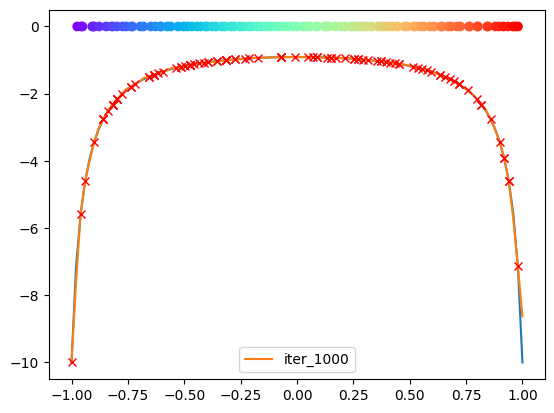

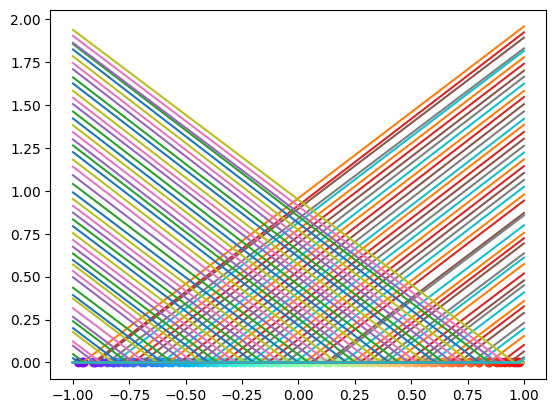

In [6]:

@jx.jit
def one_pass(H, params):
  # Forward pass with tanh
  Ws = params[0]
  bs = params[1]
  N_layers = len(Ws)
  for i in range(N_layers - 1):
    H = jnp.matmul(H, Ws[i]) + bs[i]
    H = jx.nn.relu(H)
  return H
res_last = one_pass(X_train, params)
vec_ext = jnp.c_[res_last, 1+0*res_last[:,0]]
ls = (jnp.linalg.pinv(vec_ext)@Y_train)

params[0][-1] = ls[:-1]
params[1][-1] = ls[-1:]

W0, b0 = params
W0 = W0[0]
b0 = b0[0]
plt.plot(X, Y)
plt.plot(X, forward_pass(X, params), label=f"iter_{nIter}")
plt.plot(X_train, Y_train, "rx")
plt.scatter(-b0/W0[0], [0]*b0.shape[0], c=np.linspace(0, 1, b0.shape[0]), cmap="rainbow")
plt.legend()
plt.show()

plt.plot(X, jx.nn.relu(X@W0+b0))
plt.scatter(-b0/W0[0], [0]*b0.shape[0], c=np.linspace(0, 1, b0.shape[0]), cmap="rainbow")
plt.show()

In [7]:
params

[[Array([[-1.0026978 ,  0.9996672 , -0.99446523,  1.0076146 , -0.9991488 ,
           0.9960436 , -0.99155587,  0.9909658 , -0.99898607,  0.9995013 ,
          -0.99149895,  1.0027575 , -0.9917142 ,  1.0037907 , -0.9844135 ,
           1.0028555 , -0.9892309 ,  1.0096817 , -0.99761236,  1.010871  ,
          -0.9876511 ,  1.0040957 , -0.98937976,  1.0125623 , -0.9978115 ,
           1.0127778 , -0.99665433,  1.0134549 , -0.9956491 ,  1.0097518 ,
          -0.991121  ,  1.007382  , -0.990401  ,  1.0085186 , -0.990044  ,
           1.0077558 , -0.98995924,  1.0068629 , -0.98995745,  1.0067121 ,
          -0.98986906,  1.0069067 , -0.9899031 ,  1.0069568 , -0.9899637 ,
           1.0070214 , -0.9900485 ,  1.0071456 , -0.9900801 ,  1.0071192 ,
          -0.9901959 ,  1.0046581 , -0.9948433 ,  1.0006683 , -1.0022612 ,
           0.9915993 , -1.0071719 ,  0.99565727, -1.0108763 ,  0.9931213 ,
          -1.0092717 ,  0.9921123 , -1.0093273 ,  0.99379134, -1.0102589 ,
           0.9976401 , -1

In [8]:
gL = jx.grad(lambda params: loss(params, X_train, Y_train))
ggL = jx.grad(gL)


gL(params)[0][-1], gL(params)[1][-1]#, ggL(params)

(Array([[-3.30187646e-07],
        [-4.78074071e-06],
        [ 5.40980352e-07],
        [-5.22066148e-06],
        [ 1.20299774e-07],
        [-5.80345386e-06],
        [ 9.01593467e-08],
        [-6.41142833e-06],
        [ 5.23617018e-07],
        [-7.14045655e-06],
        [ 7.51910648e-07],
        [-7.57013277e-06],
        [ 1.22019264e-06],
        [-7.99067493e-06],
        [ 1.62359174e-06],
        [-8.17276577e-06],
        [ 2.33999890e-06],
        [-8.67295239e-06],
        [ 3.29729664e-06],
        [-8.81155393e-06],
        [ 3.65532833e-06],
        [-8.86089856e-06],
        [ 4.50408152e-06],
        [-9.03197270e-06],
        [ 5.71153396e-06],
        [-9.10196195e-06],
        [ 6.54007818e-06],
        [-9.00956820e-06],
        [ 7.47482409e-06],
        [-8.88099839e-06],
        [ 8.20398418e-06],
        [-8.70938766e-06],
        [ 9.22830804e-06],
        [-8.51670029e-06],
        [ 1.03129423e-05],
        [-8.27129679e-06],
        [ 1.14722025e-05],
 